# Natural Language Querying using LangChain and openCypher on Amazon Neptune

Natural Language Querying (NLQ) is an emerging technology that allows users to interact with databases and knowledge graphs using plain language instead of rigid query languages like SQL. NLQ systems use advanced natural language processing and machine learning models to understand the intent behind a user's query and translate it into the appropriate database operations. This provides a more intuitive and user-friendly way for non-technical users to access and analyze data. 

One prominent query language designed for knowledge graphs is openCypher. openCypher is a declarative graph query language that allows for powerful graph pattern matching and traversal operations. openCypher queries express what information should be retrieved from the graph, rather than how to retrieve it, making it more accessible than lower-level graph APIs. The combination of NLQ and openCypher is a compelling approach for enabling flexible, natural interactions with complex connected data

## Introducing Amazon Neptune

Amazon Neptune is a fast, reliable, and fully managed graph database service for building and running applications with highly connected datasets, such as knowledge graphs, fraud graphs, identity graphs, and security graphs.

https://aws.amazon.com/neptune/

Amazon Neptune provides two different engine offerings, Neptune Database and Neptune Analytics. You can use with this notebook however some differences may apply for certain cells.

[Neptune Database](https://docs.aws.amazon.com/neptune/latest/userguide/intro.html) is a serverless graph database designed for superior scalability and availability. Neptune Database provides built-in security, continuous backups, and integrations with other AWS services. Neptune Global Database offers cross-region data replication for low-latency reads and writes, disaster recovery, and scalability for globally distributed applications.

[Neptune Analytics](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/what-is-neptune-analytics.html) is an analytics database engine for quickly analyzing large volumes of graph data to get insights and find trends from data stored in Amazon S3 buckets or a Neptune database. Neptune Analytics uses built-in algorithms, vector search, and in-memory computing to run queries on data with tens of billions of relationships in seconds.

## Introducing LangChain

[LangChain](https://www.langchain.com/) is an open source framework for building Generative AI applications and provides key components to combine Large Language Models (LLMs) with external data.

For this notebook, we will walk through how to use Amazon Neptune with LangChain's [`NeptuneOpenCypherQAChain`](https://api.python.langchain.com/en/latest/chains/langchain.chains.graph_qa.neptune_cypher.NeptuneOpenCypherQAChain.html) and Amazon Bedrock for the LLM.

LangChain's `NeptuneOpenCypherQAChain` provides a powerful way to enable natural language querying on top of a graph database like Amazon Neptune. The process works as follows:

1. The user provides a natural language question.
2. The system takes that question and combines it with an understanding of the schema (structure) of the underlying graph database.
3. It then uses a large language model (LLM) to generate an appropriate openCypher query based on the user's question and the graph schema.
4. The generated openCypher query is executed directly against the Neptune graph database.
5. Finally, the results of the query are returned to the user, either directly or after being summarized by another language model.

This approach allows non-technical users to interact with complex graph data using plain language questions, without needing to learn the specifics of the openCypher query language. The LLM handles the translation from natural language to the appropriate graph traversal and pattern matching operations. This makes it easier for a wider range of users to derive insights from highly connected datasets stored in a graph database like Amazon Neptune.

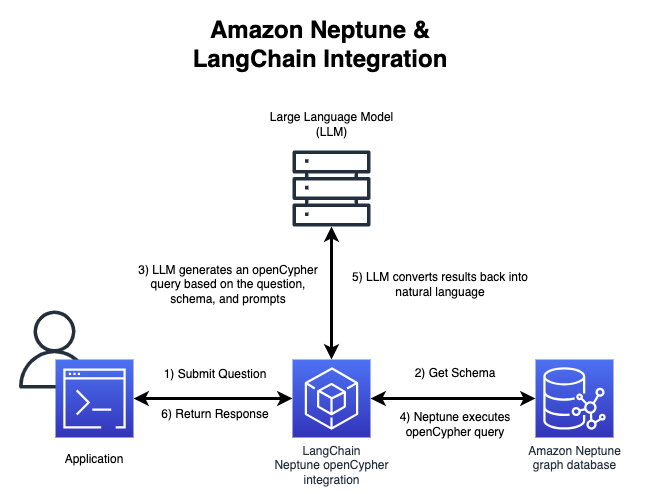

### Load our data

Now that we know how the integration with LangChain will work let's load some data and try it out.  For this notebook we will our air-routes dataset which is a property graph that contains a model of the worldwide air route network. There are vertices for airports, countries and continents. There are edges between airports and between the countries,continents and airports. Each airport has a set of properties and the edges between airports have a property that represent the distance in miles.

Please run the cell below to load the air-routes data into your graph.

In [1]:
%seed --model property_graph --dataset airports --language opencypher --run

Dropdown(description='Source type:', options=('', 'samples', 'custom'), style=DescriptionStyle(description_wid…

Dropdown(description='Data model:', layout=Layout(display='none', visibility='hidden'), options=('', 'property…

Dropdown(description='Language:', layout=Layout(display='none', visibility='hidden'), options=('', 'opencypher…

Dropdown(description='Language:', layout=Layout(display='none', visibility='hidden'), options=('', 'opencypher…

Dropdown(description='Data set:', layout=Layout(display='none', visibility='hidden'), options=(), style=Descri…

Dropdown(description='Full File Query:', index=1, layout=Layout(display='none', visibility='hidden'), options=…

Dropdown(description='Location:', layout=Layout(display='none', visibility='hidden'), options=('Local', 'S3'),…

FileChooser(path='/home/ec2-user/SageMaker', filename='', title='', show_hidden=False, select_desc='Select', c…

Button(description='Submit', layout=Layout(visibility='hidden'), style=ButtonStyle())

Output()

Output()

## Configuring our LangChain integration

### Installation

Run the cell below to install the core LangChain package as well as the LangChain Community package which contains 3rd part integrations with Amazon Neptune.

In [2]:
pip install -q langchain langchain_community langchain_aws --upgrade

Note: you may need to restart the kernel to use updated packages.


### Connecting LangChain to your graph

To connect LangChain to your graph you need to specify the configuration to create the connection.  For Neptune Database, you create a `NeptuneGraph` object and pass it the host and port.  For Neptune Analytics, you create a `NeptuneAnalyticsGraph` and pass it the graph identifier.

In [3]:
from langchain_community.graphs import NeptuneGraph, NeptuneAnalyticsGraph
import graph_notebook as gn

config = gn.configuration.get_config.get_config()

if config.neptune_service =='neptune-db':
    print("Connecting to a Neptune Database")
    graph = NeptuneGraph(
        host=config.host,
        port=config.port
    )
else:
    print("Connecting to a Neptune Analytics graph")
    graph_id = config.host.split('.')[0]
    graph = NeptuneAnalyticsGraph(graph_identifier="<neptune-analytics-graph-id>")

Connecting to a Neptune Database


### Returning the Graph Schema

As part of the connection sequence, LangChain uses the summary API and queries to fetch an implicit schema from the graph.  You can view this schema using the `schema` property of our graph object.

In [4]:
print(graph.schema)


        Node properties are the following:
        [{'properties': [{'property': 'desc', 'type': 'STRING'}, {'property': 'code', 'type': 'STRING'}, {'property': 'id', 'type': 'STRING'}], 'labels': 'continent'}, {'properties': [{'property': 'desc', 'type': 'STRING'}, {'property': 'code', 'type': 'STRING'}, {'property': 'id', 'type': 'STRING'}], 'labels': 'country'}, {'properties': [{'property': 'author', 'type': 'STRING'}, {'property': 'id', 'type': 'STRING'}, {'property': 'date', 'type': 'STRING'}, {'property': 'code', 'type': 'STRING'}, {'property': 'desc', 'type': 'STRING'}], 'labels': 'version'}, {'properties': [{'property': 'lat', 'type': 'DOUBLE'}, {'property': 'icao', 'type': 'STRING'}, {'property': 'longest', 'type': 'INTEGER'}, {'property': 'region', 'type': 'STRING'}, {'property': 'runways', 'type': 'INTEGER'}, {'property': 'city', 'type': 'STRING'}, {'property': 'continent', 'type': 'STRING'}, {'property': 'id', 'type': 'STRING'}, {'property': 'country', 'type': 'STRING'}, {

### Configuring Amazon Bedrock with Anthropic Claude V3 Sonnet

Next, we need to setup Amazon Bedrock as our LLM we will use for generating queries.  In this example, we'll use the Anthropic Claude V3.5 Sonnet Foundational Model.

**Note** Running using Amazon Bedrock requires that this notebook have permissions to execute the model and that the model is enabled for use in the current region.  Details are available [here](https://python.langchain.com/v0.2/docs/integrations/llms/bedrock/).


In [5]:
from langchain_aws import ChatBedrock
import boto3
client = boto3.client('bedrock-runtime')

llm= ChatBedrock(model_id = "anthropic.claude-3-sonnet-20240229-v1:0", client=client)

### Creating our QA Chain

The final step before we can start querying our graph is to setup our `NeptuneOpenCypherQAChain` and pass it the graph and llm connections we have previously created.

In [6]:
from langchain.chains import NeptuneOpenCypherQAChain

chain = NeptuneOpenCypherQAChain.from_llm(llm=llm, graph=graph)

## Querying our graph

Now that we have setup the QA chain for our graph we are ready to start asking questions.  We do this using the `invoke()` method on our chain and passing it a question.  For example, let's look at some of the questions from our security graph sample application.

In [9]:
chain.invoke('''Where can I fly from Anchorage with no stops?''')

{'query': 'Where can I fly from Anchorage with no stops?',
 'result': "Based on the provided information, some destinations you can fly to from Anchorage with no stops include Fairbanks International Airport, Bethel Airport, Adak Airport, Dillingham Airport, Kodiak Airport, Kenai Municipal Airport, Homer Airport, Iliamna Airport, Juneau International Airport, King Salmon Airport, McGrath Airport, Aniak Airport, Nome Airport, Ralph Wien Memorial Airport, St George Airport, Deadhorse Airport, Sand Point Airport, St Mary's Airport, St Paul Island Airport, Unalakleet Airport, Valdez Pioneer Field, and Yelizovo Airport."}

In [10]:
chain.invoke('''Can I fly from Anchorage to Austin with a stop in Seattle?''')

{'query': 'Can I fly from Anchorage to Austin with a stop in Seattle?',
 'result': 'Yes, you can fly from Anchorage (ANC) to Austin (AUS) with a stop in Seattle (SEA). The provided information shows flight routes from Anchorage to Seattle and then from Seattle to Austin, indicating that it is possible to travel between these cities with a stopover in Seattle.'}

In [11]:
chain.invoke('''Find the top 10 airports sorted by the number of outgoing routes? 
Return just the airport code and the number of routes''')

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'FRA has 310 routes, IST has 309 routes, CDG has 294 routes, AMS has 285 routes, MUC has 271 routes.'

### Returning only the answer

In certain situations you may want to only return the results of the query and not have the LLM summarize them.  To accomplish this you can set the `return_direct` to `True` when creating your chain.  Let's do that and rerun the last query to see the difference.

In [12]:
chain = NeptuneOpenCypherQAChain.from_llm(llm=llm, graph=graph, return_direct=True)

chain.invoke('''Find the top 10 airports sorted by the number of outgoing routes? 
Return just the airport code and the number of routes''')

[{'airport.code': 'FRA', 'outgoingRoutes': 310},
 {'airport.code': 'FRA', 'outgoingRoutes': 310},
 {'airport.code': 'IST', 'outgoingRoutes': 309},
 {'airport.code': 'IST', 'outgoingRoutes': 309},
 {'airport.code': 'CDG', 'outgoingRoutes': 294},
 {'airport.code': 'CDG', 'outgoingRoutes': 294},
 {'airport.code': 'AMS', 'outgoingRoutes': 285},
 {'airport.code': 'AMS', 'outgoingRoutes': 285},
 {'airport.code': 'MUC', 'outgoingRoutes': 271},
 {'airport.code': 'MUC', 'outgoingRoutes': 271}]

### Seeing the intermediate query 

LLMs are a powerful tool but when generating queries from natural language they do not always get the intent or syntax correct, leading to errors during execution.  To help in debugging these sorts of scenarios you can set the `return_intermediate_steps` and `verbose` flags on your chain to get back additional information about what is happening and the generated query.

In [13]:
chain = NeptuneOpenCypherQAChain.from_llm(llm=llm, graph=graph, return_intermediate_steps=True, verbose=True)

chain.invoke('''What are the airports in Anchorage, AK?''')



> Entering new NeptuneOpenCypherQAChain chain...
Generated Cypher:
MATCH (a:airport)
WHERE a.city = "Anchorage" AND a.country = "AK"
RETURN a;

Full Context:
[]

> Finished chain.


"I don't know the answer since no relevant information was provided."

As we can see, the generated query above has valid syntax but is not giving the correct answer, in this case because it is using an incorrect region.  To assist with this we can provide our LLM with some extra instructions in the prompt.

### Providing Additional Prompting Guidance

One common optimization when working with LLMs is to provide additional instructions to the prompt used by the LLM.  With our QA chain we can provide these through the `extra_instructions` flag, which appends these instructions to the generation prompt.

In the example above let's tell our LLM to append the country code the region and to do case insensitive comparisons for strings.

In [14]:
chain = NeptuneOpenCypherQAChain.from_llm(llm=llm, graph=graph, return_intermediate_steps=True, verbose=True, 
extra_instructions="""
Perform all string comparisons on case insensitive version of the strings.
When comparing on region it needs to include the country, for example California would be US-CA and Washington would be US-WA.
""")

chain.invoke('''What are the airports in Anchorage, AK?''')



> Entering new NeptuneOpenCypherQAChain chain...
Generated Cypher:
MATCH (a:airport)
WHERE LOWER(a.region) = 'us-ak' AND LOWER(a.city) = 'anchorage'
RETURN a;

Full Context:
[{'a': {'~id': '09d35644-5ae2-44a9-ad29-5746e237bb1f', '~entityType': 'node', '~labels': ['airport'], '~properties': {'id': '2', 'code': 'ANC', 'icao': 'PANC', 'city': 'Anchorage', 'desc': 'Anchorage Ted Stevens', 'region': 'US-AK', 'runways': 3, 'longest': 12400, 'elev': 151, 'country': 'US', 'continent': 'NA', 'lat': 61.1744003295898, 'lon': -149.996002197266}}}, {'a': {'~id': '7bfa29a2-3000-4667-beaf-8f8b23517660', '~entityType': 'node', '~labels': ['airport'], '~properties': {'id': '2', 'code': 'ANC', 'icao': 'PANC', 'city': 'Anchorage', 'desc': 'Anchorage Ted Stevens', 'region': 'US-AK', 'runways': 3, 'longest': 12400, 'elev': 151, 'country': 'US', 'continent': 'NA', 'lat': 61.1744003295898, 'lon': -149.996002197266}}}]

> Finished chain.


'The airports in Anchorage, AK are Anchorage Ted Stevens with the code ANC and ICAO code PANC. It has 3 runways with the longest being 12400 feet, an elevation of 151 feet, located at latitude 61.1744003295898 and longitude -149.996002197266.'

As we can see this additional prompting help the LLM generate a better query that returns the correct results.  

## Next Steps

In this notebook we walked through the basics of performing Natural Language Querying using LangChain and openCypher with Amazon Neptune.  
However, it's important to recognize the inherent nature of large language models (LLMs) - they will not always generate the correct query, even if the original natural language question was clear. When the generated query does not produce the expected results, we'll need to employ techniques not covered in this notebook such as query validation, prompt tuning, and query rewriting to troubleshoot and refine the process.